# Forth Stage

In [1]:
from get_data import *
from simulation import *
from optimization import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import tqdm
import seaborn as sns
import os
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
target_stock_code = '2330'
target_side = 'bid'
res_dict = {}  # Target dictionary to store results, don't update this dictionary for testing different objective function params

In [3]:
files_df = get_path_df(stock_code=target_stock_code, side=target_side)
gb = files_df.groupby(['stock_code', 'side', 'ts', 'tm'])

### Optimization Result of 1 Set of Objective Function Params

In [4]:
obj_kwargs = {'lmda': 1, 't_func': lambda x: np.sqrt(x / 1000.)}

In [5]:
iter_tqdm = tqdm.tqdm(gb, desc='Calculating', ncols=200, total=len(gb.groups))
for k, df in iter_tqdm:
    iter_tqdm.set_description(f'Calculating[{"|".join(k)}]')
    if k not in res_dict.keys():
        res_dict[k] = get_sim_res(path_ls=df['path'].unique().tolist())
    res_score = obj(res_dict[k]['pnl'], res_dict[k]['duration'], **obj_kwargs)
    res_score = res_score[np.logical_and(~np.isnan(res_score), ~np.isinf(res_score))]
    res_dict[k].update({
        'scores': res_score, 
        'score_mean': np.nanmean(res_score), 
        'score_std': np.nanstd(res_score)
    })

Calculating[2330|bid|95|95]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 819/819 [11:49<00:00,  1.15it/s]


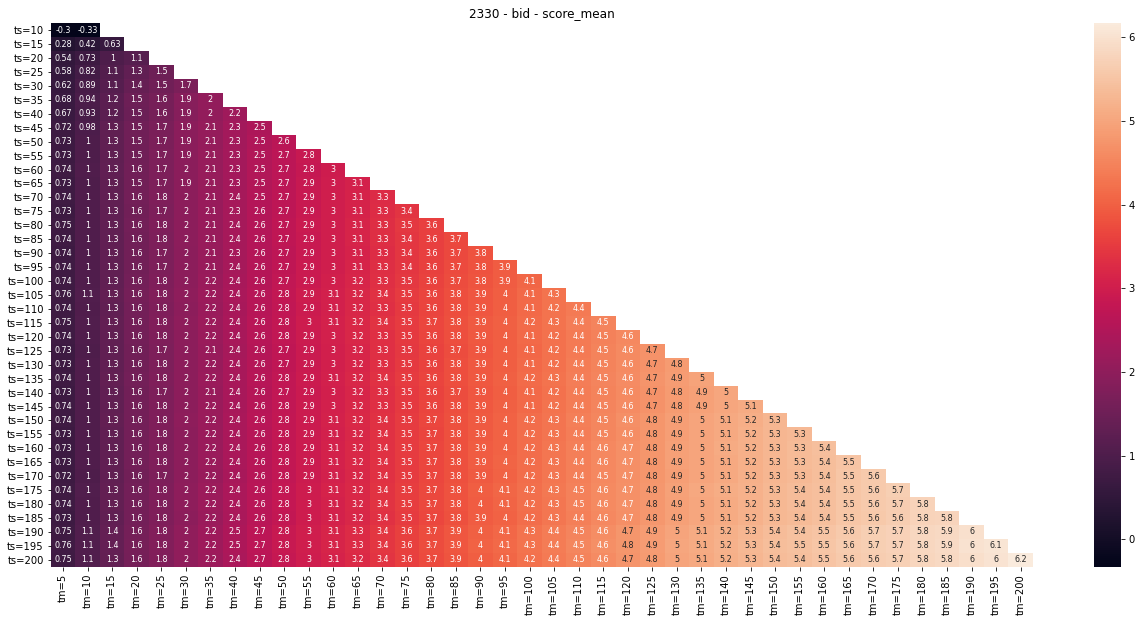

In [6]:
plot_heatmap(stock_code=target_stock_code, side=target_side, plot_attri='score_mean', res_dict=res_dict)

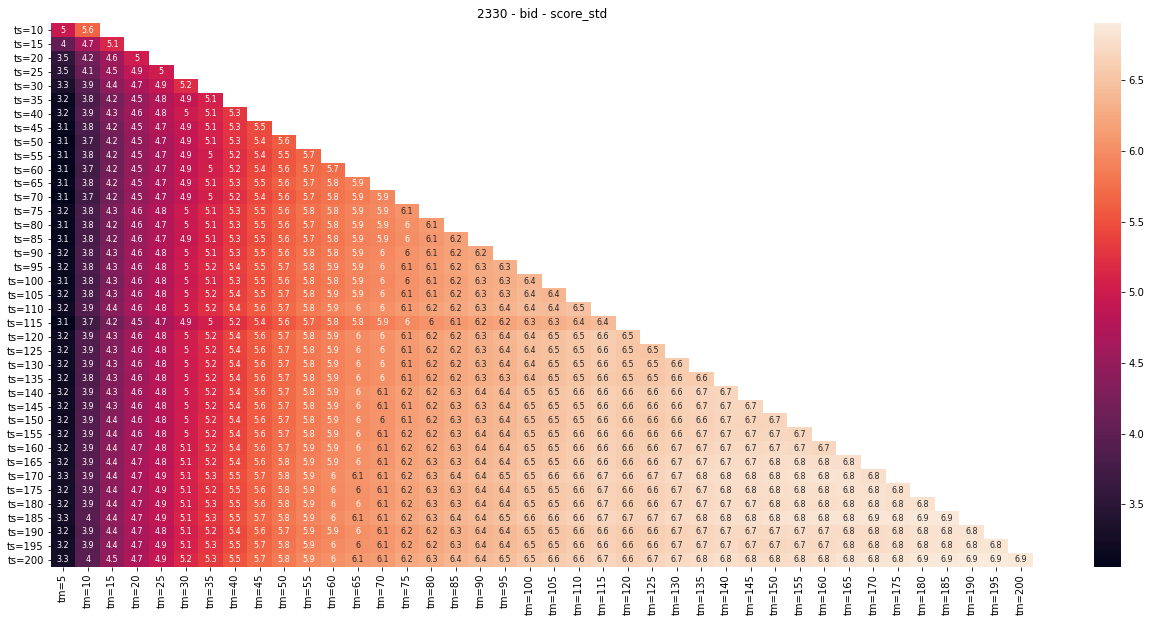

In [7]:
plot_heatmap(stock_code=target_stock_code, side=target_side, plot_attri='score_std', res_dict=res_dict)

### Only TAKE Cases

In [ ]:
res_dict = {}
iter_tqdm = tqdm.tqdm(gb, desc='Calculating', ncols=200, total=len(gb.groups))
for k, df in iter_tqdm:
    iter_tqdm.set_description(f'Calculating[{"|".join(k)}]')
    
    # Case to filtered here
    take_cond = lambda xdf: xdf['case'] == 'TAKE'
    
    if k not in res_dict.keys():
        res_dict[k] = get_sim_res(path_ls=df['path'].unique().tolist(), cond=take_cond)
    res_score = obj(res_dict[k]['pnl'], res_dict[k]['duration'], **obj_kwargs)
    res_score = res_score[np.logical_and(~np.isnan(res_score), ~np.isinf(res_score))]
    res_dict[k].update({
        'scores': res_score, 
        'score_mean': np.nanmean(res_score), 
        'score_std': np.nanstd(res_score)
    })

In [ ]:
plot_heatmap(stock_code=target_stock_code, side=target_side, plot_attri='score_mean', res_dict=res_dict)

In [ ]:
plot_heatmap(stock_code=target_stock_code, side=target_side, plot_attri='score_std', res_dict=res_dict)

### Vary Lambda

In [11]:
res_dict = {}
lmda_ls = list(range(1, 11))
plot_key_ls = [(target_stock_code, target_side, str(i), str(i)) for i in range(10, 210, 10)]
iter_tqdm = tqdm.tqdm(gb, desc='Varying Lambda', ncols=200, total=len(gb.groups))
for k, df in iter_tqdm:
    iter_tqdm.set_description(f'Calculating[{"|".join(k)}]')
    if k not in plot_key_ls:
        continue
    if k not in res_dict.keys():
        res_dict[k] = get_sim_res(path_ls=df['path'].unique().tolist(), cond=None)
    obj_kwargs_ls = [{'lmda': i, 't_func': lambda x: np.sqrt(x / 1000.)} for i in lmda_ls]
    res_score_ls = [obj(res_dict[k]['pnl'], res_dict[k]['duration'], **obj_kwargs) for obj_kwargs in obj_kwargs_ls]
    res_score_ls = [res_score[np.logical_and(~np.isnan(res_score), ~np.isinf(res_score))] for res_score in res_score_ls]
    res_dict[k].update({
        'score_ls': res_score_ls, 
        'score_mean_ls': [np.nanmean(res_score) for res_score in res_score_ls], 
        'score_std_ls': [np.nanstd(res_score) for res_score in res_score_ls]
    })

Calculating[2330|bid|95|95]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 819/819 [00:14<00:00, 56.38it/s]


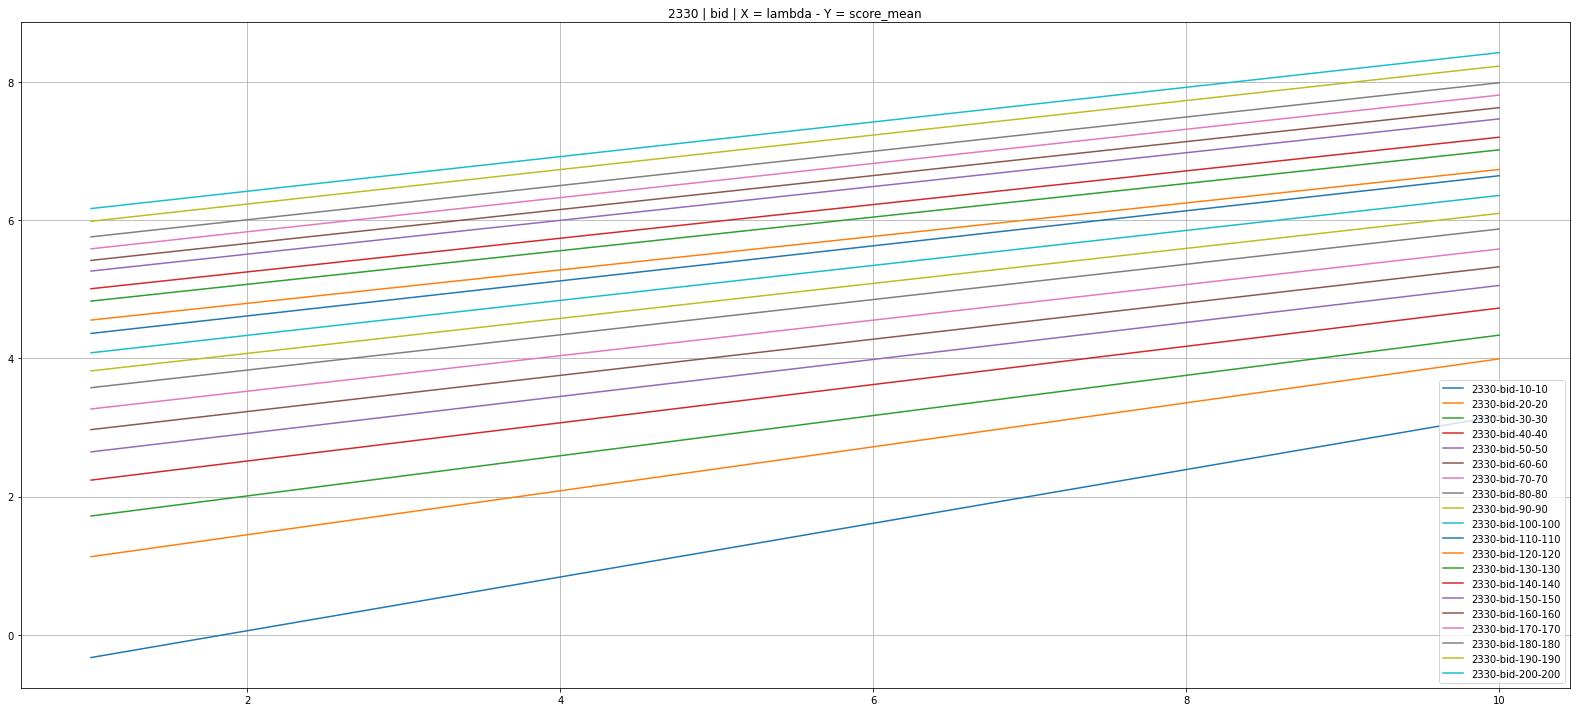

In [15]:
plot_attri = 'score_mean'
fig, ax = plt.subplots(figsize=(22, 10))
for k in plot_key_ls:
    plot_line = res_dict[k][f'{plot_attri}_ls']
    ax.plot(lmda_ls, plot_line, label='-'.join(k))
ax.set_title(f'{target_stock_code} | {target_side} | X = lambda - Y = {plot_attri}')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()